In [1]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn


from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM
from abstractWeight import AbstractWeight as AW
from abstractNN import AbstractNN as NN
from custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os

import numpy as np
device = torch.device('cpu')

In [2]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


In [3]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
     
        x=self.maxpool(x)
     
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,
                         conv1_eps_weight,
                         conv1_eps_bias,
                         conv2_eps_weight,
                         conv2_eps_bias,
                         fc1_eps_weight,
                         fc1_eps_bias, 
                         fc2_eps_weight,
                         fc2_eps_bias,
                         add_symbol=False,
                         device=torch.device("cpu")):
        self.device=device
        AR.max_symbol = np.inf
        AM.max_symbol = np.inf
        AR.recycling = 1
        AM.recycling =1 
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)
      
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv1,x,x_true,conv1_eps_weight , conv1_eps_bias,device=self.device)
     
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
   
        symb_1 = len(x)
       
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv2,x,x_true,conv2_eps_weight,conv2_eps_bias,device=self.device)
       
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
      
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,add_symbol=add_symbol,device=self.device)
    
      
        symb_conv2 =len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc1,x,x_true,fc1_eps_weight,fc1_eps_bias,device=self.device)
     
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
  
  
        symb_fc1 = len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc2,x,x_true,fc2_eps_weight,fc2_eps_bias,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        
        
        return x,x_min,x_max,x_true,symb_1,symb_conv2, symb_fc1
        

Label:5


torch.Size([2, 1, 28, 28])

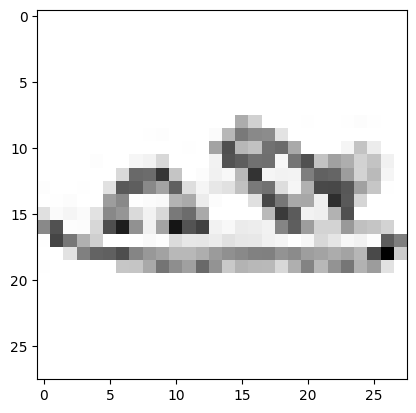

In [4]:

import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[1310]
plt.imshow(1-img[0],cmap='gray')
print(f"Label:{label}")
img.shape
from abstract import abstractTensor as AT

x=AT(img,alpha =torch.tensor([]))
x=x.abstract_tensor()
x.shape

In [5]:
model = AbstractNN()

In [6]:
scale = 0.0001
conv1_eps_weight = torch.tensor([])
conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
conv1_eps_weight.values = scale*(1)*torch.ones_like(conv1_eps_weight.indices)
conv1_eps_bias = torch.tensor([])
conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
conv1_eps_bias.values = scale*(1)*torch.ones_like(conv1_eps_bias.indices)


conv2_eps_weight = torch.tensor([])
conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
conv2_eps_weight.values = scale*(1)*torch.ones_like(conv2_eps_weight.indices)
conv2_eps_bias = torch.tensor([])
conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
conv2_eps_bias.values = scale*(1)*torch.ones_like(conv2_eps_bias.indices)

fc1_eps_weight = torch.tensor([])
fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
fc1_eps_weight.values = scale*(1)*torch.ones_like(fc1_eps_weight.indices)
fc1_eps_bias = torch.tensor([])
fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
fc1_eps_bias.values = scale*(1)*torch.ones_like(fc1_eps_bias.indices)


fc2_eps_weight = torch.tensor([])
fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
fc2_eps_weight.values = scale*(1)*torch.ones_like(fc2_eps_weight.indices)
fc2_eps_bias = torch.tensor([])
fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
fc2_eps_bias.values = scale*(1)*torch.ones_like(fc2_eps_bias.indices)

In [7]:
model = AbstractNN()

In [8]:
with torch.no_grad():

   result,x_min,x_max,x_true,_,_,_=model.abstract_forward(x,
                                                    conv1_eps_bias=conv1_eps_bias,
                                                    conv1_eps_weight=conv1_eps_weight,
                                                    conv2_eps_weight = conv2_eps_weight,
                                                    conv2_eps_bias = conv2_eps_bias,
                                                    fc1_eps_weight =fc1_eps_weight,
                                                    fc1_eps_bias = fc1_eps_bias, 
                                                    fc2_eps_weight = fc2_eps_weight,
                                                    fc2_eps_bias = fc2_eps_bias,

                                                    
                                                    add_symbol=True)

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

y_min       =  tensor([-0.0928, -0.0832, -0.0933, -0.0304,  0.0000,  0.0612, -0.1022, -0.0818,
        -0.0706, -0.0687])
y_max       =  tensor([0.2055, 0.1371, 0.1459, 0.0332, 0.0000, 0.4078, 0.3517, 0.2547, 0.2412,
        0.0943])
center Ztp  =  tensor([0.0564, 0.0269, 0.0263, 0.0014, 0.0000, 0.2345, 0.1247, 0.0865, 0.0853,
        0.0128])
y_true      =  tensor([[0.0293, 0.0000, 0.0000, 0.0000, 0.0000, 0.2374, 0.1049, 0.0663, 0.0679,
         0.0000]])
y_max-x_min =  tensor([0.2983, 0.2203, 0.2392, 0.0636, 0.0000, 0.3467, 0.4539, 0.3365, 0.3119,
        0.1631])
Trash symbol=  tensor([0.0603, 0.0487, 0.0557, 0.0170, 0.0000, 0.0246, 0.0705, 0.0600, 0.0481,
        0.0401])


In [9]:
result.shape

torch.Size([301039, 10])

In [338]:
import matplotlib.pyplot as plt
import numpy as np
def plot_dominance(result,x_min,x_max,x_true):
       y_min       =  np.array(x_min)
       y_max       =  np.array(x_max)
       center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
       y_true      =  np.expand_dims(np.array(x_true[:])[0],axis =1)



       




       x_scale = np.arange(len(y_min))
       D =np.stack((y_min,y_max),axis=1)

       print(D.shape)
       print(center_Ztp.shape)
       print(y_true.shape)
       # plot:

       fig,ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
       ax.eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
       ax.eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
       ax.eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

       ax.set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
              ylim=(np.min(D)-1, np.max(D)+1))
       plt.ylabel("Value of the abstract domain")
       plt.title("Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model")
       plt.legend()
       plt.show()


In [11]:
model = AbstractNN()

In [ ]:
result[len_symb_c2+294911-4:len_symb_c2+294911+2,5]
test[:label]
test[label+1:]

tensor([8, 9])

In [ ]:
model.fc2[1].weight.data.shape

In [ ]:
conv1_eps_bias.values

In [ ]:
list

In [ ]:
conv1_eps_weight.values
model.conv1.weight.data

In [ ]:
test = np.arange(0,10,1)
test[1:5]
test[5:10]

In [23]:
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)

In [249]:
eval.evaluate_model(dataset_test)

EPOCH ACCURACY = 80.86 %


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(80.8600)

In [ ]:
torch.save(model.state_dict(), f'abstractLearn.pth')

In [22]:
model.load_state_dict(torch.load('dataset/FMNIST.pth'))

<All keys matched successfully>

In [228]:
test = torch.arange(0,10,1)
test[len(test)-1]

tensor(9)

In [ ]:
reste = 55 %10

In [114]:
int(10**7*time.time()%10)

0

In [210]:
import time
np.random.seed()
label = None
while label!= 2: 
       
        index = np.random.randint(0,5000)
        print(index)
        img, label = dataset_train[index]
print(index)

3472
4230
1378
4130
3284
4700
4032
4032


In [164]:
def make_indice_and_values_tupple():
    tupple = torch.tensor([])
    tupple.indices = torch.tensor([])
    tupple.values = torch.tensor([])
    return tupple
test = make_indice_and_values_tupple()
test.indices

tensor([])

In [295]:
xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

In [296]:
xticklabels[label]

'Coat'

  0%|          | 0/100 [00:00<?, ?it/s]

0
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


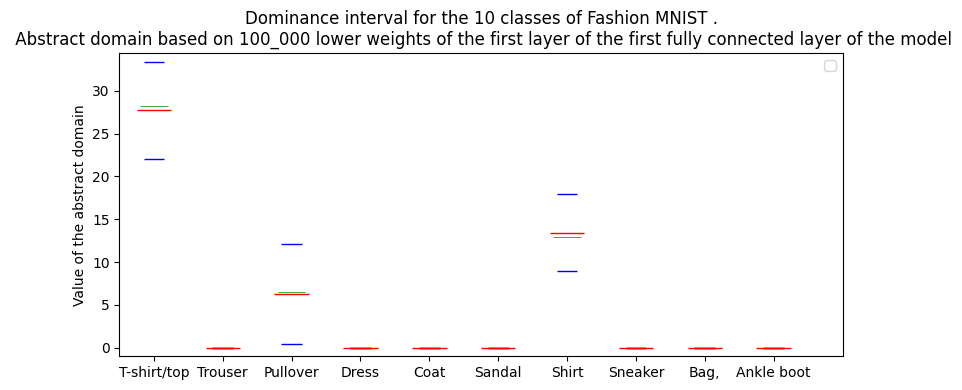

  1%|          | 1/100 [00:18<31:03, 18.83s/it]

1
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


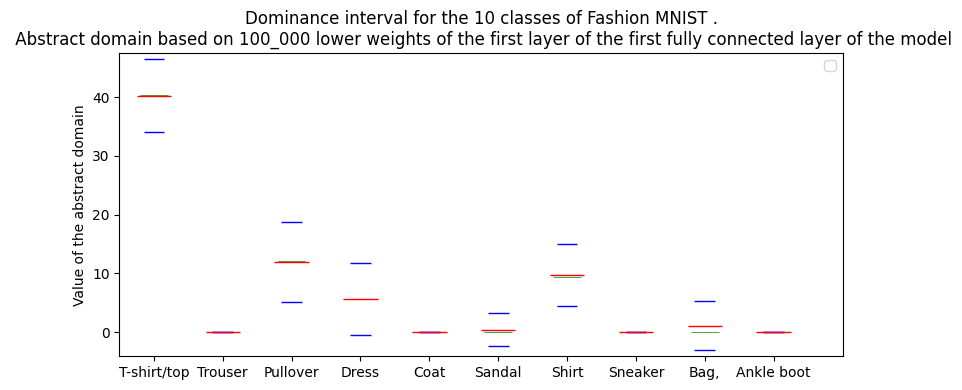

  2%|▏         | 2/100 [00:36<29:22, 17.98s/it]

2
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


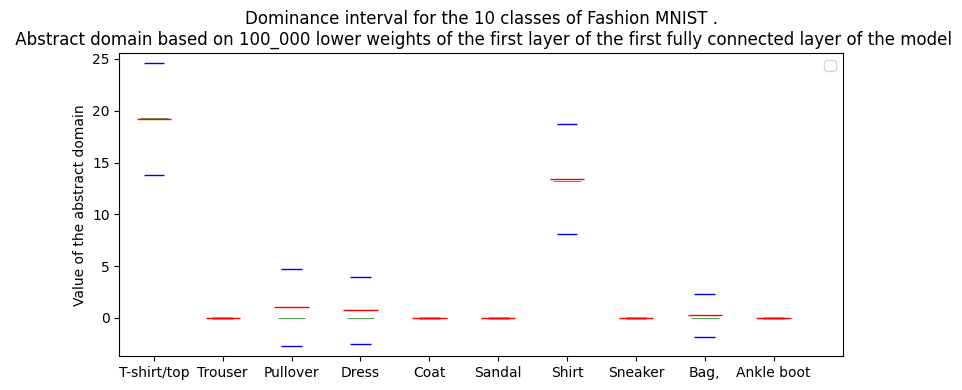

  3%|▎         | 3/100 [01:02<35:16, 21.82s/it]

3
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


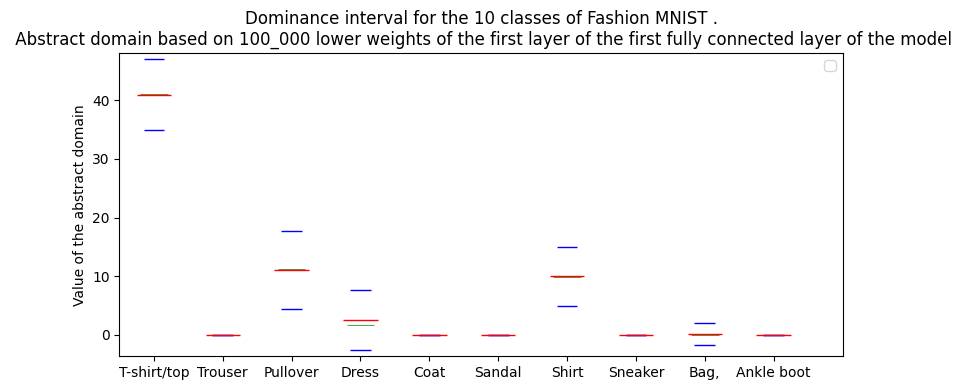

  4%|▍         | 4/100 [01:21<32:50, 20.53s/it]

4
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


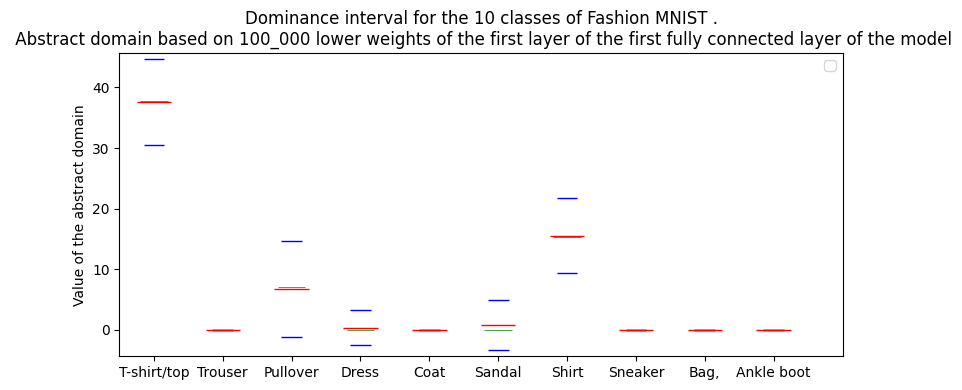

  5%|▌         | 5/100 [01:40<31:43, 20.04s/it]

5
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


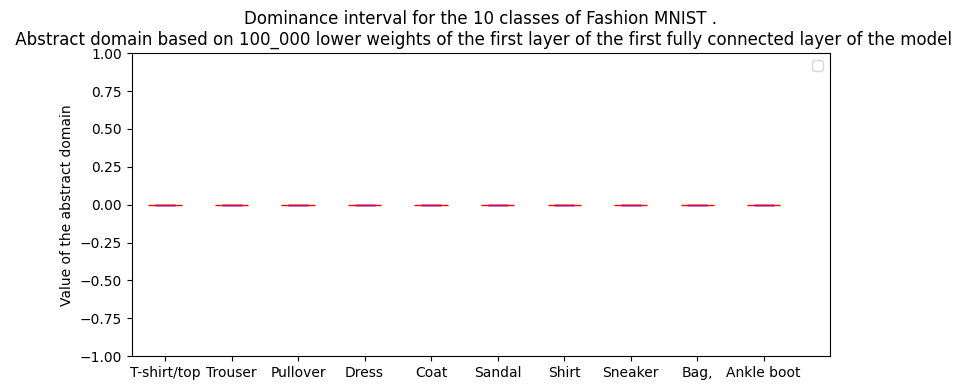

  6%|▌         | 6/100 [01:59<31:09, 19.89s/it]

6
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


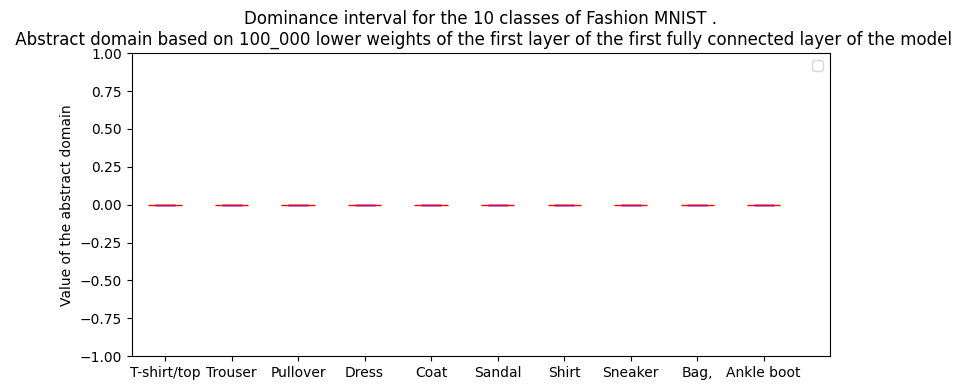

  7%|▋         | 7/100 [02:23<32:44, 21.13s/it]

7
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


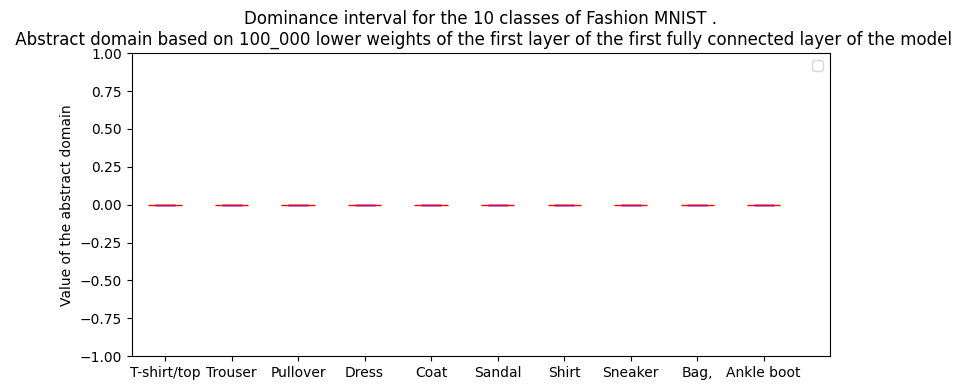

  8%|▊         | 8/100 [02:43<31:50, 20.76s/it]

8
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


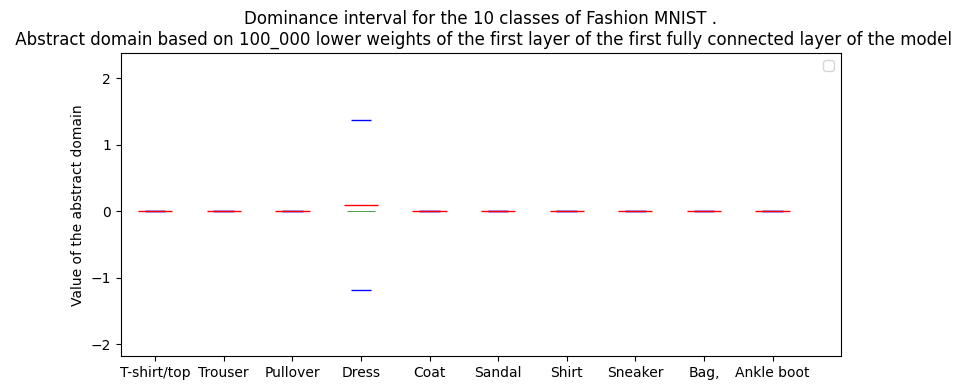

  9%|▉         | 9/100 [03:02<30:24, 20.05s/it]

9
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


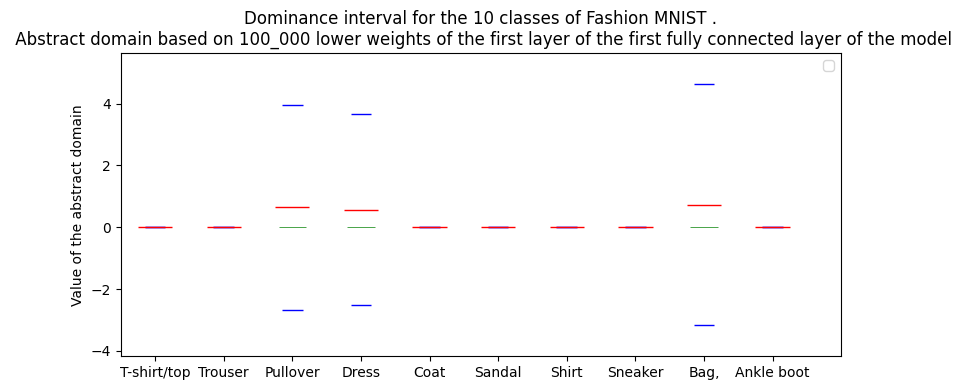

 10%|█         | 10/100 [03:20<29:30, 19.67s/it]

10
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


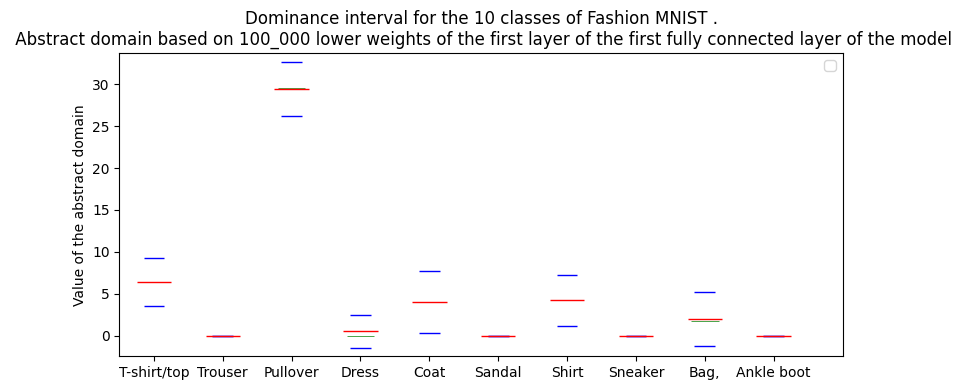

 11%|█         | 11/100 [03:56<36:13, 24.42s/it]

11
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


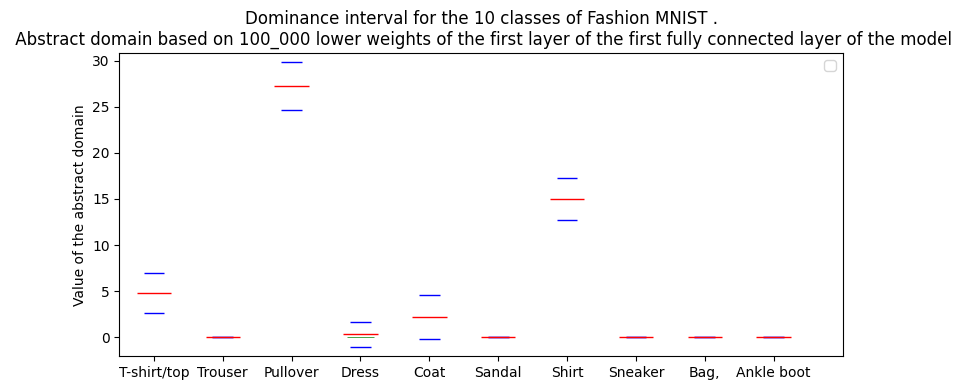

 12%|█▏        | 12/100 [04:29<39:49, 27.16s/it]

12
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


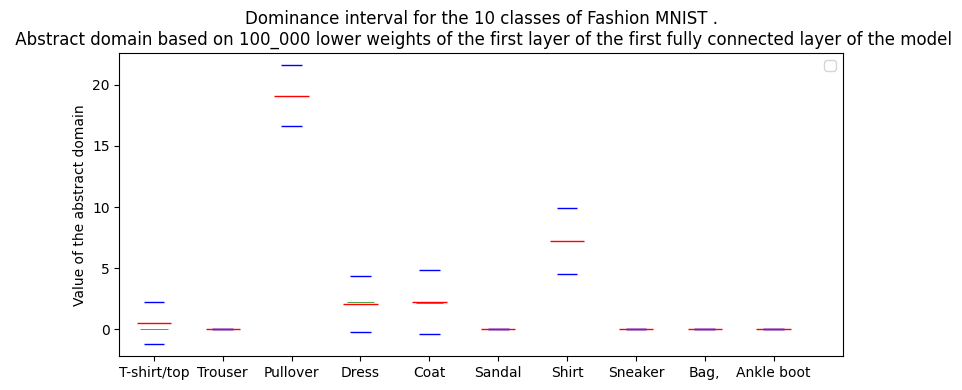

 13%|█▎        | 13/100 [05:03<42:18, 29.18s/it]

13
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


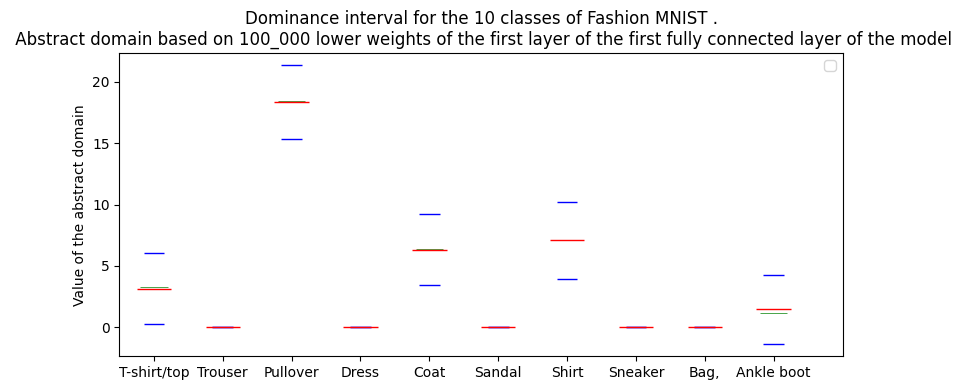

 14%|█▍        | 14/100 [05:21<37:02, 25.84s/it]

14
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


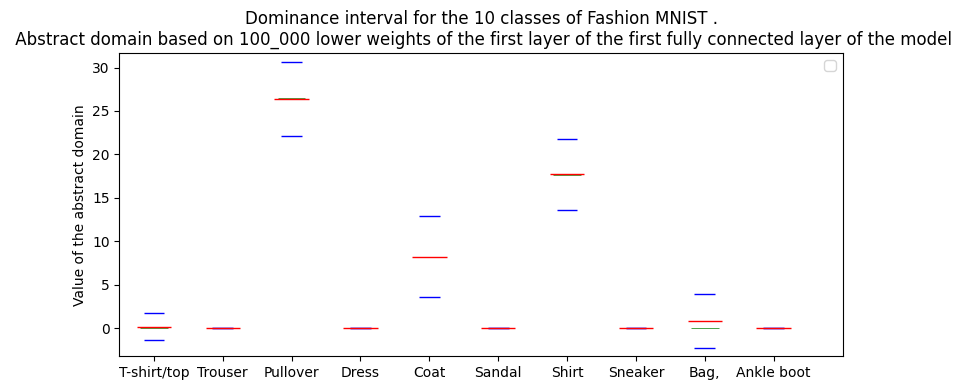

 15%|█▌        | 15/100 [05:41<33:56, 23.96s/it]

15
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


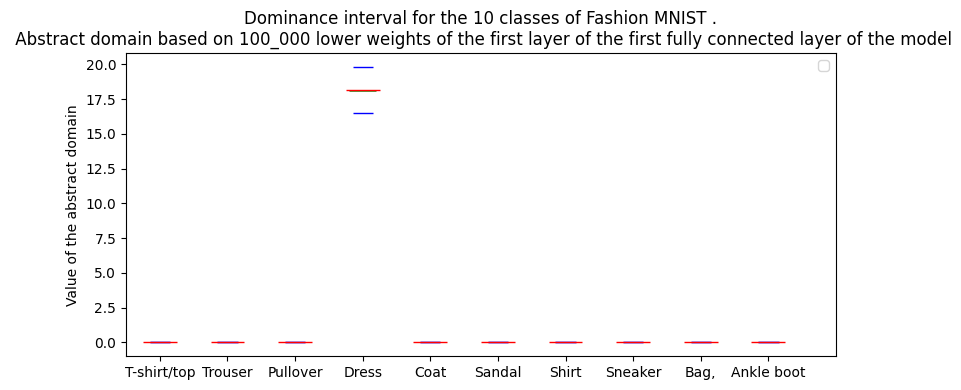

 16%|█▌        | 16/100 [06:10<36:02, 25.74s/it]

16
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


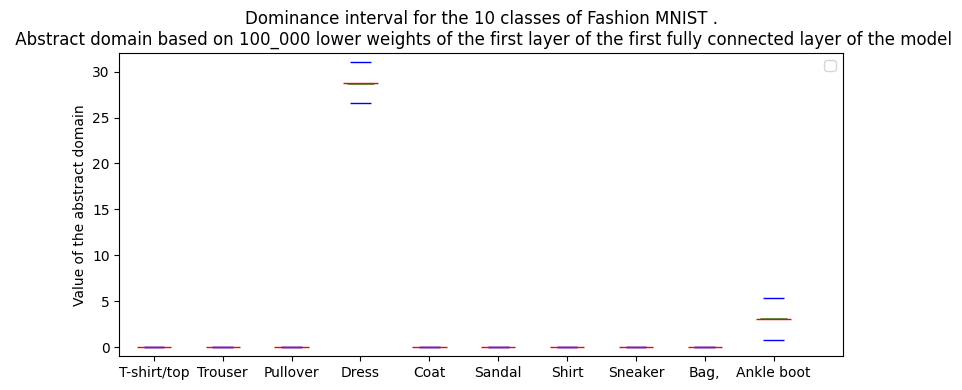

 17%|█▋        | 17/100 [06:30<32:55, 23.80s/it]

17
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


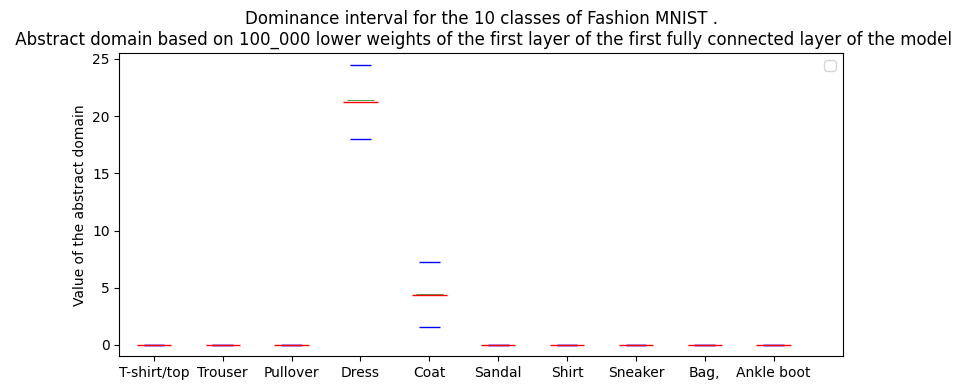

 18%|█▊        | 18/100 [06:48<30:16, 22.15s/it]

18
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


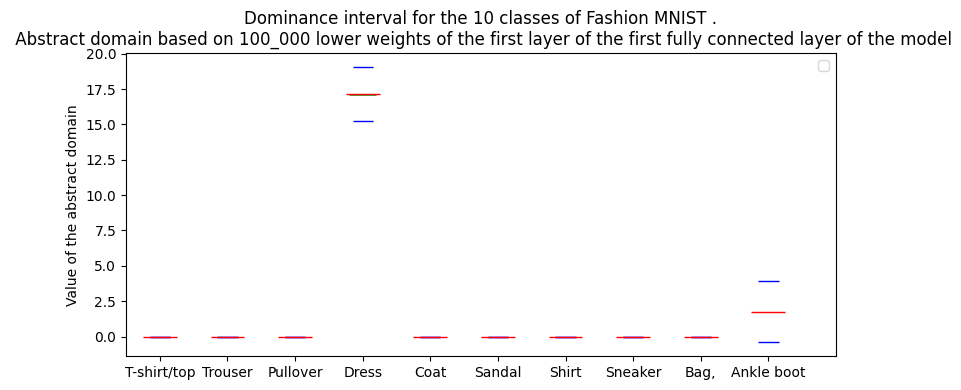

 19%|█▉        | 19/100 [07:06<28:19, 20.99s/it]

19
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


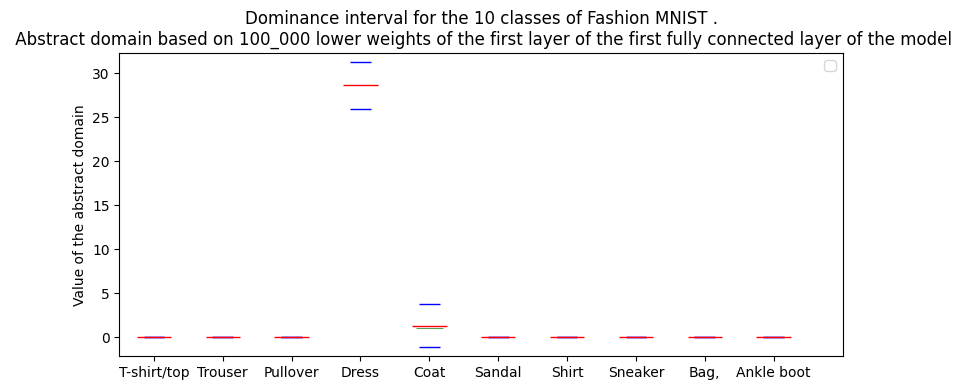

 20%|██        | 20/100 [07:25<27:00, 20.25s/it]

20
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


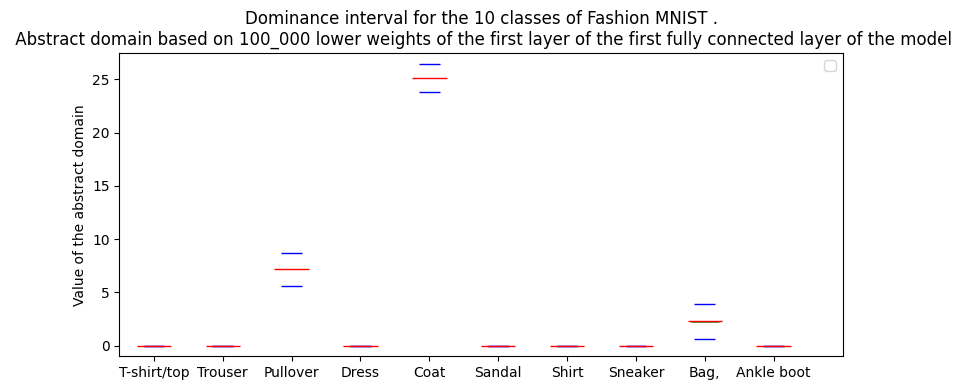

 21%|██        | 21/100 [07:42<25:35, 19.43s/it]

21
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


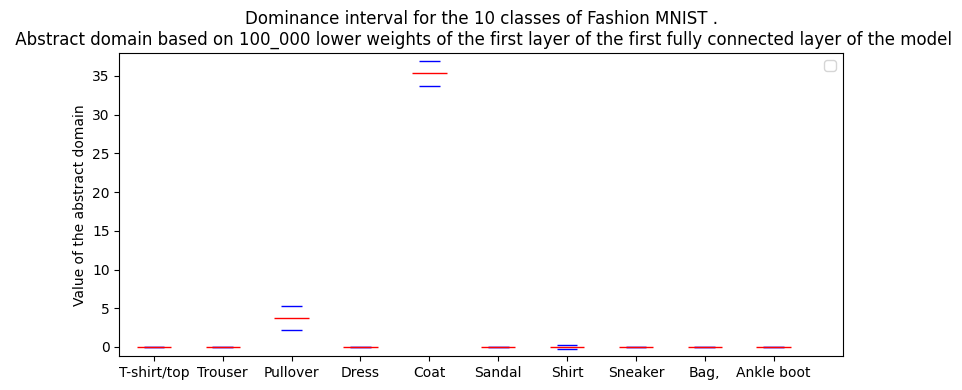

 22%|██▏       | 22/100 [08:02<25:21, 19.51s/it]

22
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


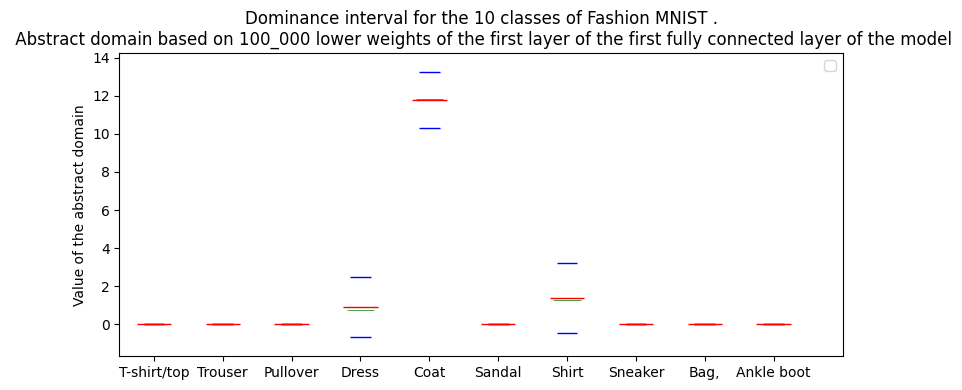

 23%|██▎       | 23/100 [08:35<30:15, 23.57s/it]

23
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


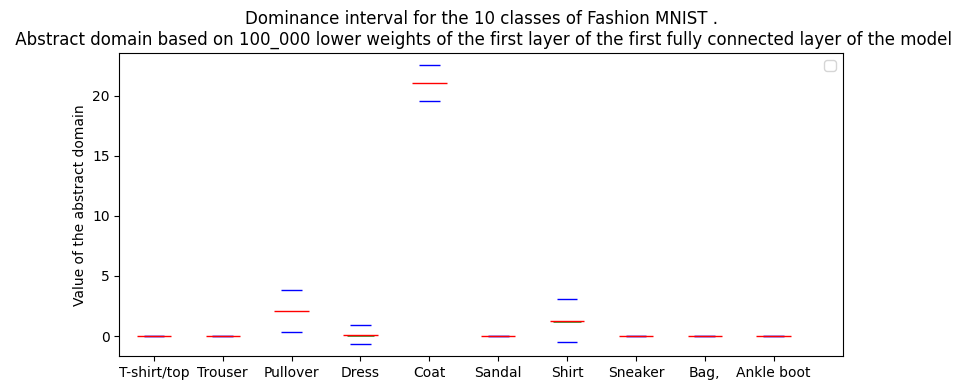

 24%|██▍       | 24/100 [09:08<33:35, 26.52s/it]

24
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


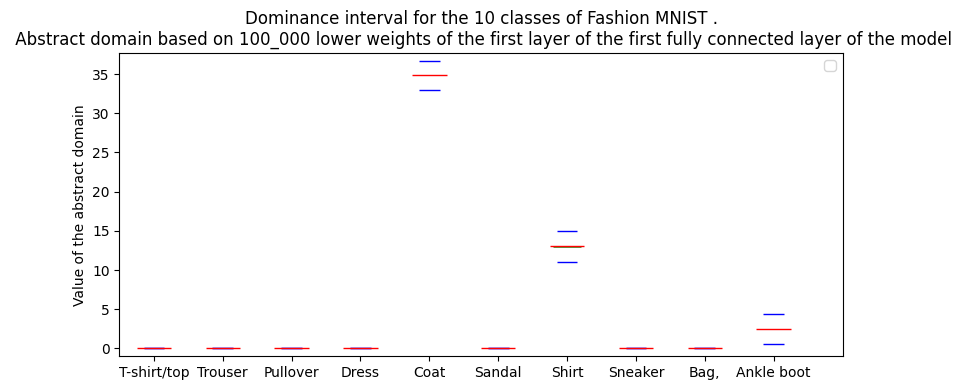

 25%|██▌       | 25/100 [09:37<33:52, 27.10s/it]

25
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


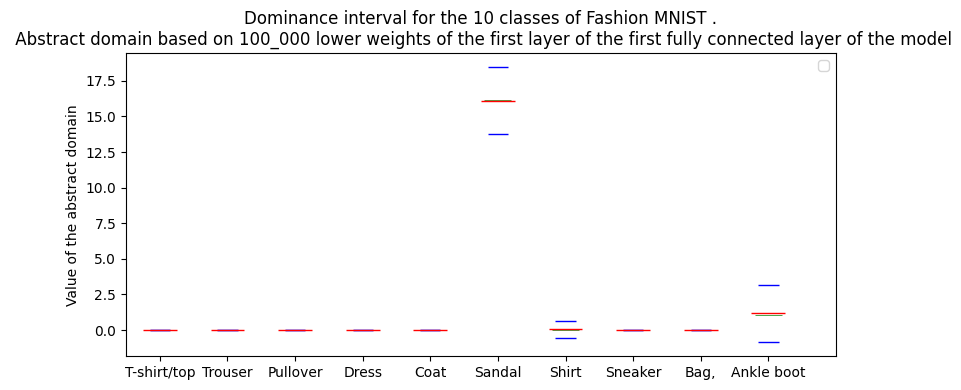

 26%|██▌       | 26/100 [10:05<33:49, 27.42s/it]

26
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


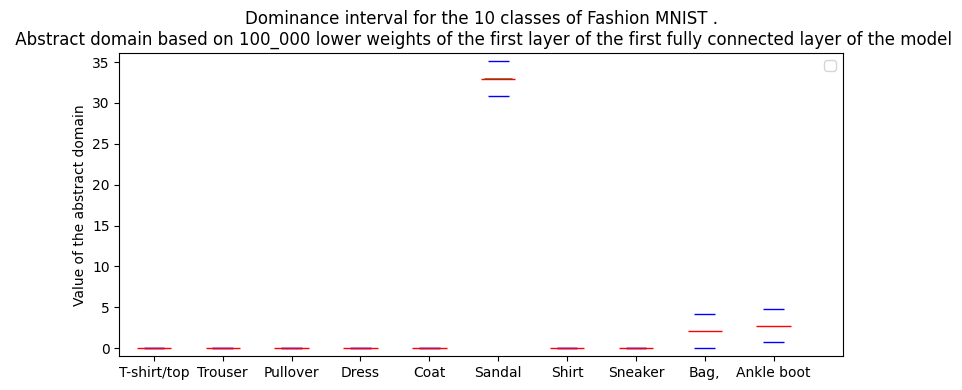

 27%|██▋       | 27/100 [10:30<32:27, 26.68s/it]

27
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


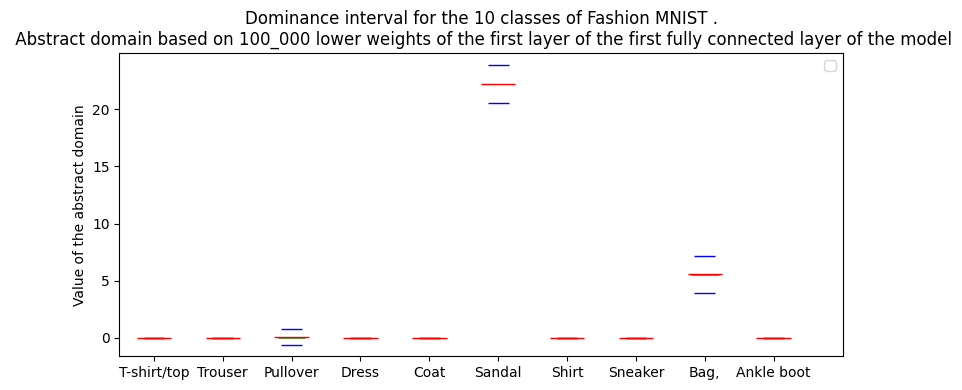

 28%|██▊       | 28/100 [10:50<29:36, 24.67s/it]

28
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


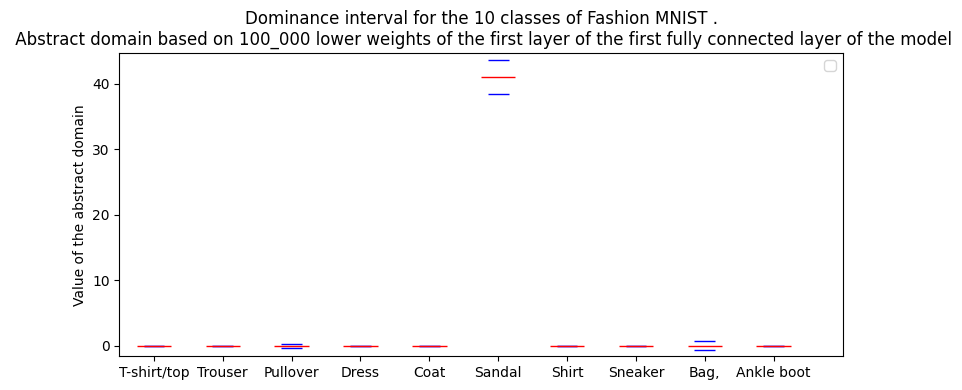

 29%|██▉       | 29/100 [11:20<31:13, 26.39s/it]

29
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


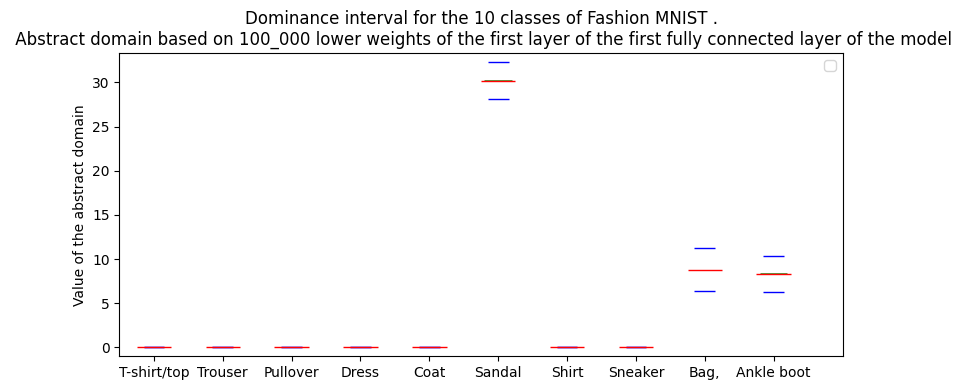

 30%|███       | 30/100 [11:39<28:10, 24.16s/it]

30
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


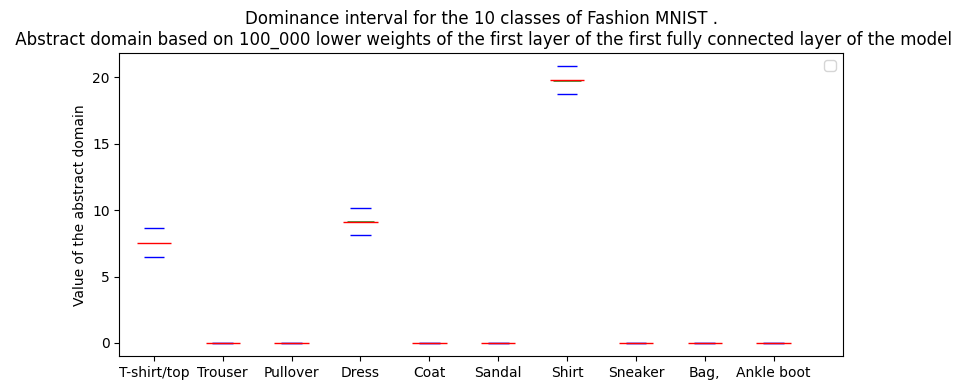

 31%|███       | 31/100 [12:13<30:54, 26.88s/it]

31
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


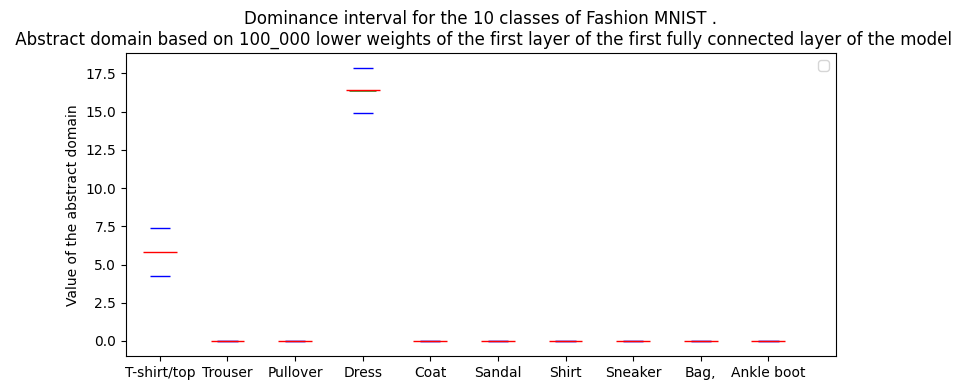

 32%|███▏      | 32/100 [12:32<27:59, 24.70s/it]

32
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


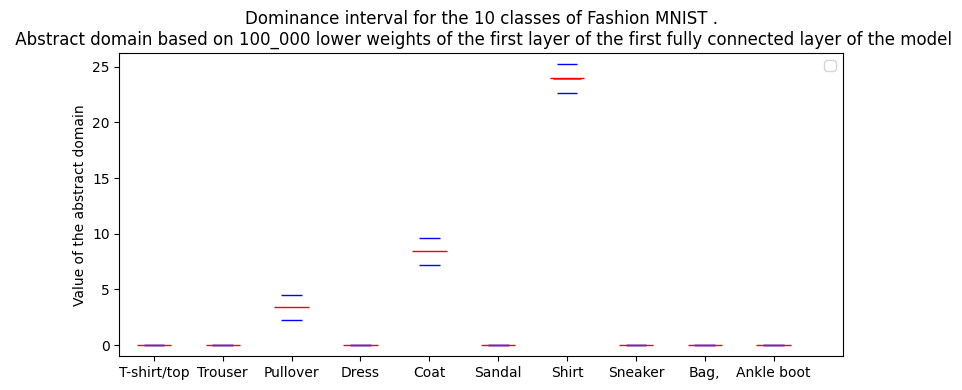

 33%|███▎      | 33/100 [12:50<25:24, 22.75s/it]

33
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


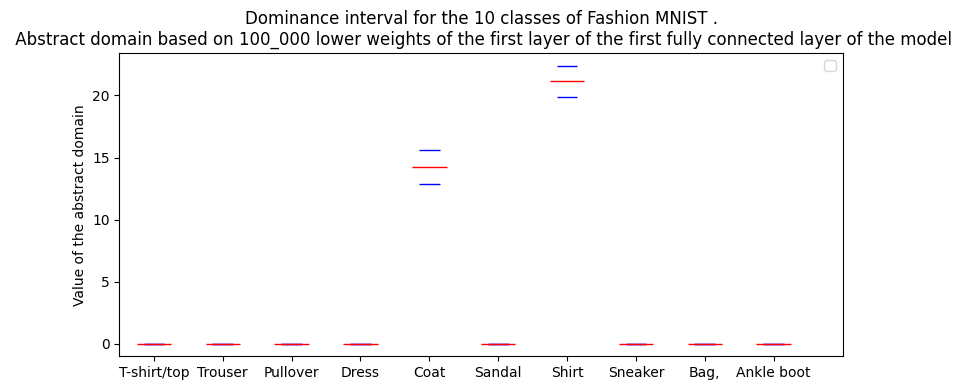

 34%|███▍      | 34/100 [13:27<29:38, 26.95s/it]

34
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


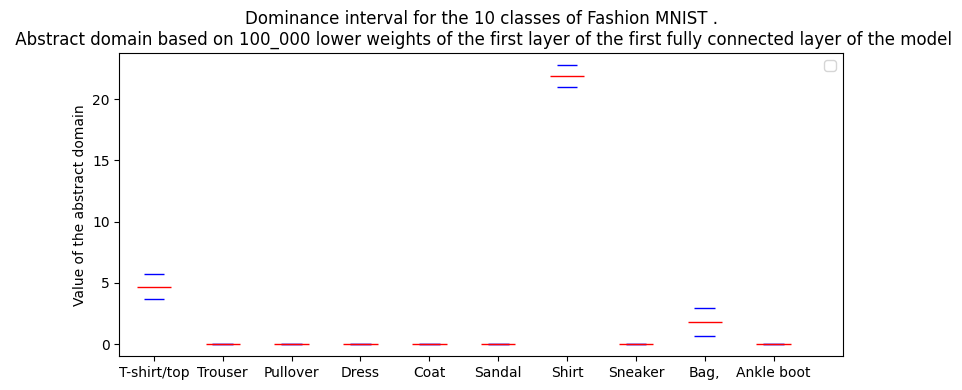

 35%|███▌      | 35/100 [13:46<26:26, 24.40s/it]

35
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


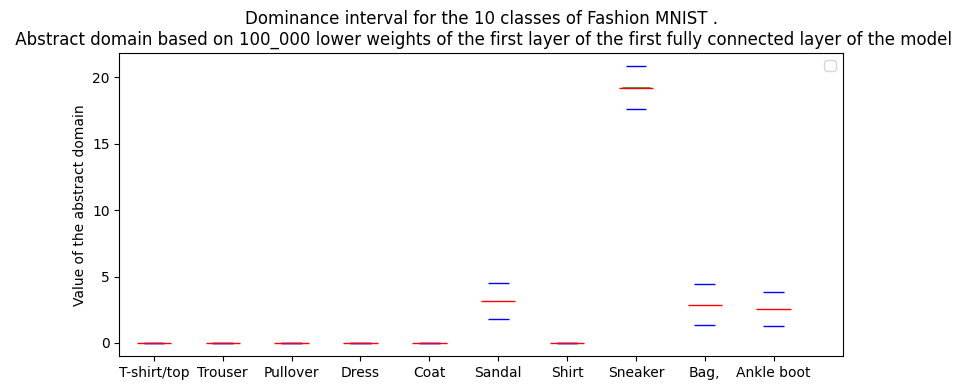

 36%|███▌      | 36/100 [14:03<23:54, 22.42s/it]

36
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


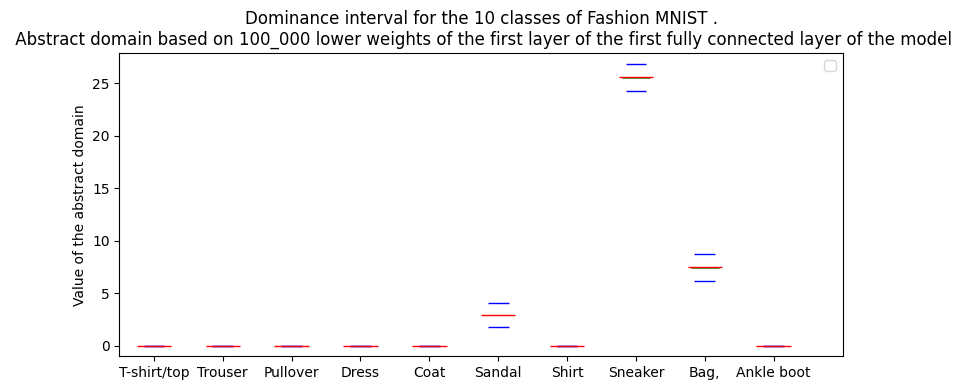

 37%|███▋      | 37/100 [14:36<26:51, 25.58s/it]

37
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


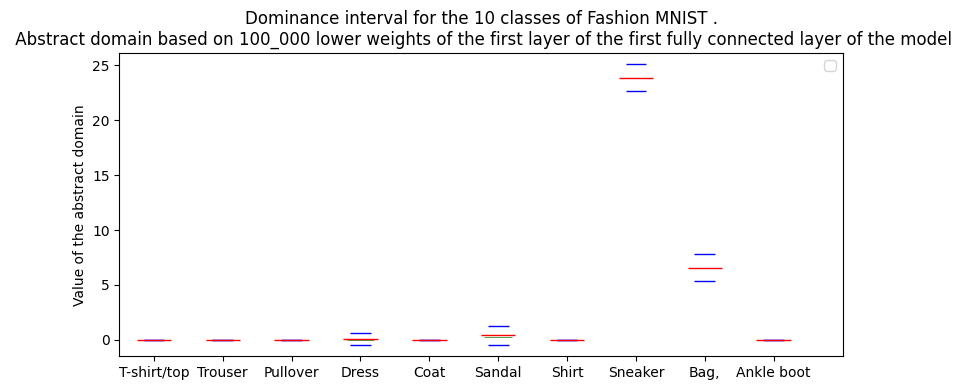

 38%|███▊      | 38/100 [15:10<28:50, 27.92s/it]

38
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


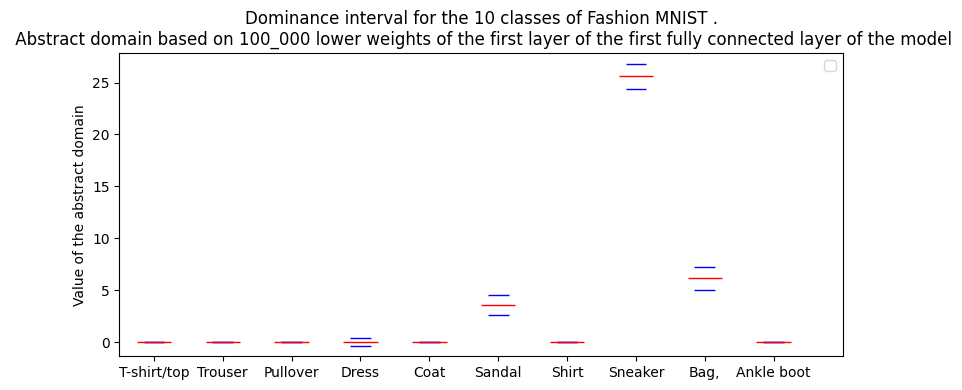

 39%|███▉      | 39/100 [15:42<29:35, 29.11s/it]

39
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


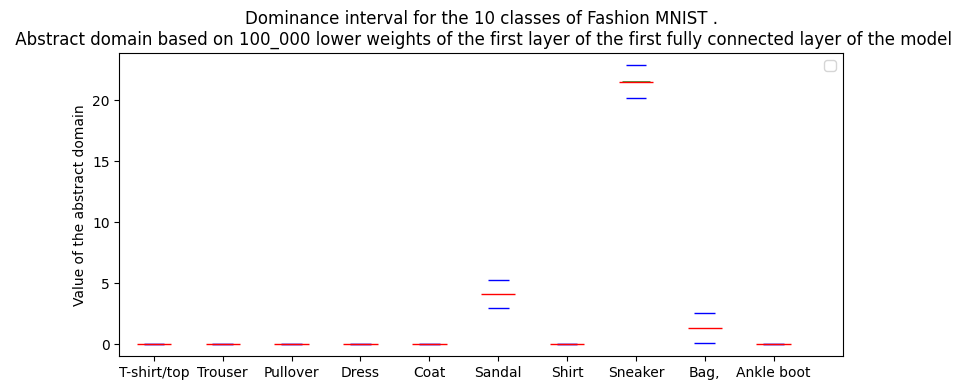

 40%|████      | 40/100 [16:00<25:57, 25.96s/it]

40
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


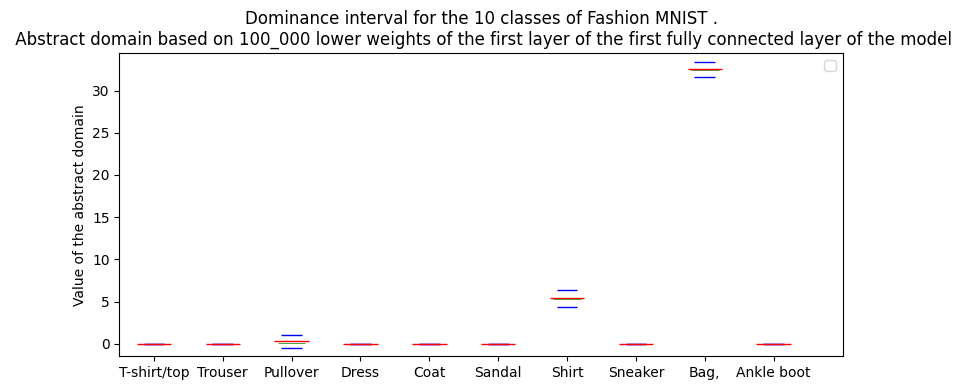

 41%|████      | 41/100 [16:33<27:34, 28.04s/it]

41
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


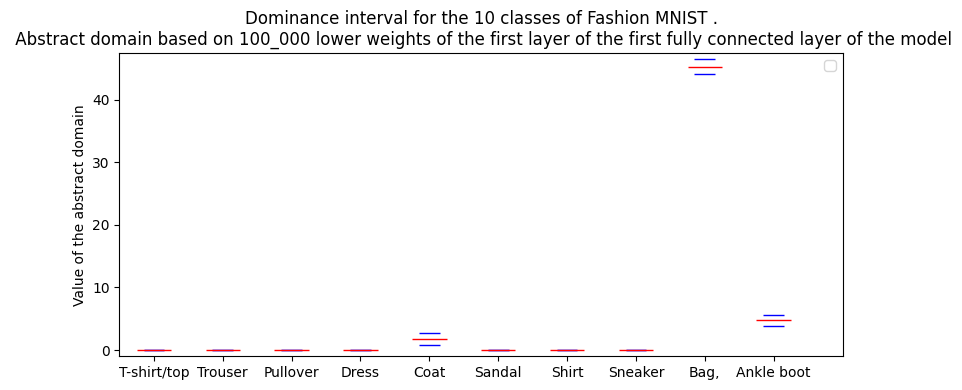

 42%|████▏     | 42/100 [17:04<27:57, 28.92s/it]

42
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


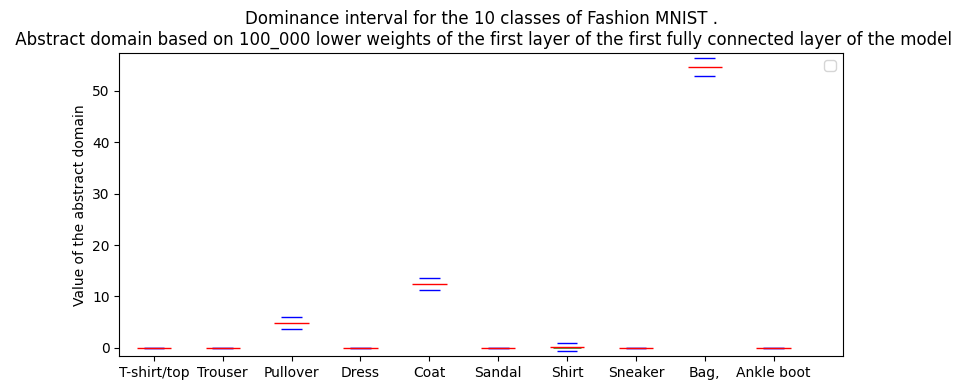

 43%|████▎     | 43/100 [17:24<24:49, 26.13s/it]

43
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


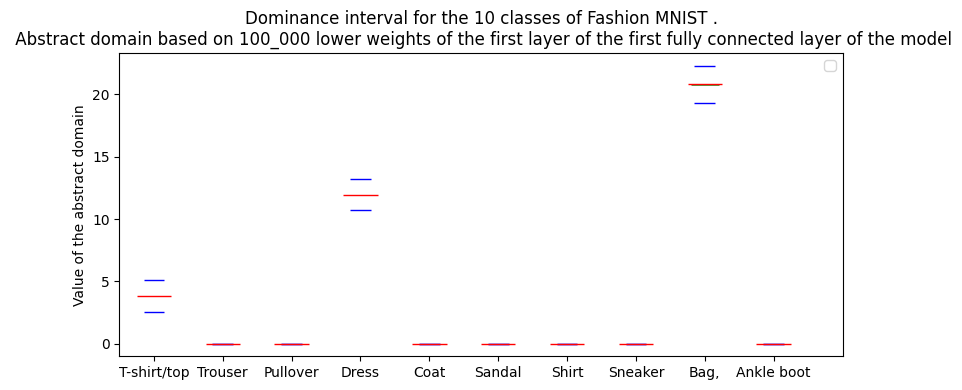

 44%|████▍     | 44/100 [17:41<21:50, 23.41s/it]

44
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


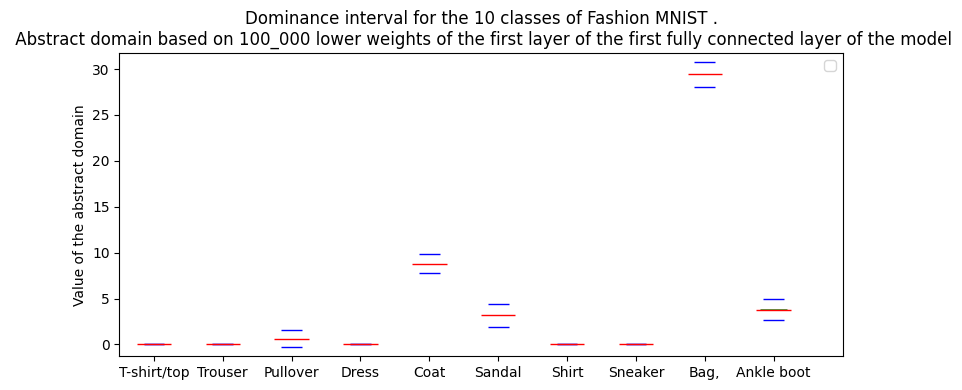

 45%|████▌     | 45/100 [18:16<24:38, 26.89s/it]

45
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


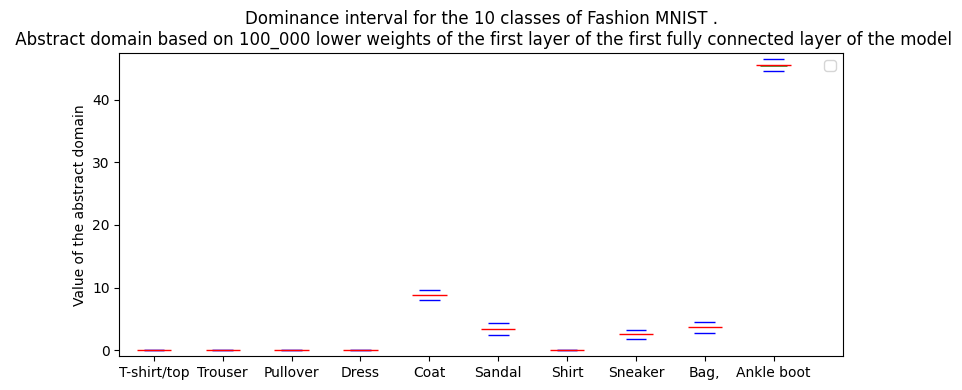

 46%|████▌     | 46/100 [18:35<22:10, 24.63s/it]

46
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


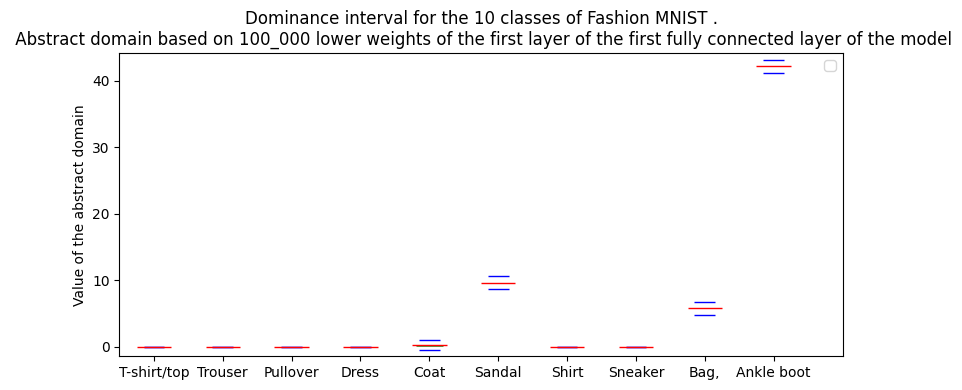

 47%|████▋     | 47/100 [19:09<24:09, 27.35s/it]

47
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


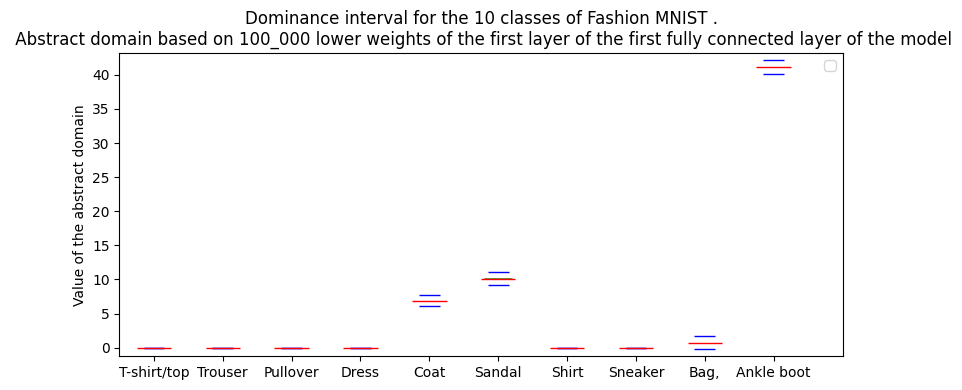

 48%|████▊     | 48/100 [19:29<21:42, 25.04s/it]

48
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


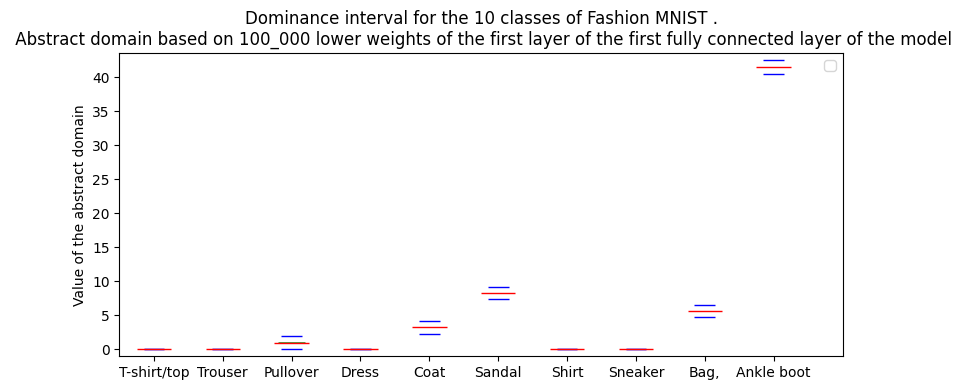

 49%|████▉     | 49/100 [19:48<19:44, 23.23s/it]

49
torch.Size([786, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


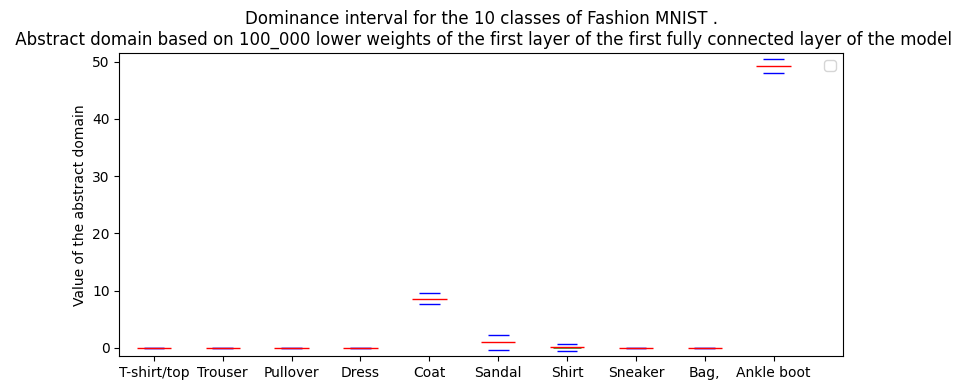

 50%|█████     | 50/100 [20:20<21:45, 26.11s/it]

50


 50%|█████     | 50/100 [20:31<20:31, 24.63s/it]


KeyboardInterrupt: 

In [361]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
abstract_network = True
scale =0.01
xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []




for i in tqdm(range(100)):
    print(i)
    if i%10 ==0:
        scale = 0.001/(i/10+1)
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*conv1__weight_span*torch.ones_like(conv1_eps_weight.indices)
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*conv1__bias_span*torch.ones_like(conv1_eps_bias.indices)


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*conv2_weight_span*torch.ones_like(conv2_eps_weight.indices)
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale/2*conv2_bias_span*torch.ones_like(conv2_eps_bias.indices)

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale/1*fc1_weight_span*torch.ones_like(fc1_eps_weight.indices)
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale/1*fc1_bias_span*torch.ones_like(fc1_eps_bias.indices)


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale/100*fc2_weight_span*torch.ones_like(fc2_eps_weight.indices)
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale/100*fc2_bias_span*torch.ones_like(fc2_eps_bias.indices)


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        fc1_eps_bias = make_indice_and_values_tupple()
        fc1_eps_weight = make_indice_and_values_tupple()
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

  
    while label!= int(i/5): 
        index = np.random.randint(0,5000)
        
        img, label = dataset_train[index]

    name_label_list.append(xticklabels[label])
    num_label_list.append(label)
   
    img_list.append(img)
    
    x=AT(img,alpha =0.001*scale*torch.ones(28*28))
    x=x.abstract_tensor()
    print(x.shape)

    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    true_predict_list.append(torch.argmax(x_true))
    plot_dominance(result,x_min,x_max,x_true)
    


    concatenated_tensors = []
    concatenated_heatmap_tensors =[]
    for j in range(10):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

    img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(10):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(10,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


    conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
    conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
    conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

    conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
    fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
    fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
    fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

    """
    k_min = 0.01
    k_plus = 0.6
    if i>9:
        k_plus = 0.5
        k_min = 0.05
    if i>19:
        k_plus = 0.4
        k_min = 0.1
    if i>39:
        k_min = 0.2
    """
    
    """
    model.conv1.weight.data =model.conv1.weight.data+k_plus*(concatenated_tensors[label]-k_min*(torch.sum(concatenated_tensors[:label],dim =0)+torch.sum(concatenated_tensors[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv1.bias.data = model.conv1.bias.data + k_plus*(concatenated_bias_tensors[label]-k_min*(torch.sum(concatenated_bias_tensors[:label],dim = 0)+torch.sum(concatenated_bias_tensors[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.conv2.weight.data =model.conv2.weight.data+k_plus*(concatenated_tensors_2[label]-k_min*(torch.sum(concatenated_tensors_2[:label],dim =0)+torch.sum(concatenated_tensors_2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv2.bias.data = model.conv2.bias.data + k_plus*(concatenated_bias_tensors_2[label]-k_min*(torch.sum(concatenated_bias_tensors_2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_2[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(concatenated_tensors_fc1[label]-k_min*(torch.sum(concatenated_tensors_fc1[:label],dim =0)+torch.sum(concatenated_tensors_fc1[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(concatenated_bias_tensors_fc1[label]-k_min*(torch.sum(concatenated_bias_tensors_fc1[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc1[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(concatenated_tensors_fc2[label]-k_min*(torch.sum(concatenated_tensors_fc2[:label],dim =0)+torch.sum(concatenated_tensors_fc2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(concatenated_bias_tensors_fc2[label]-k_min*(torch.sum(concatenated_bias_tensors_fc2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc2[label+1:],dim = 0)))#/torch.no
    """
   

   
    

    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


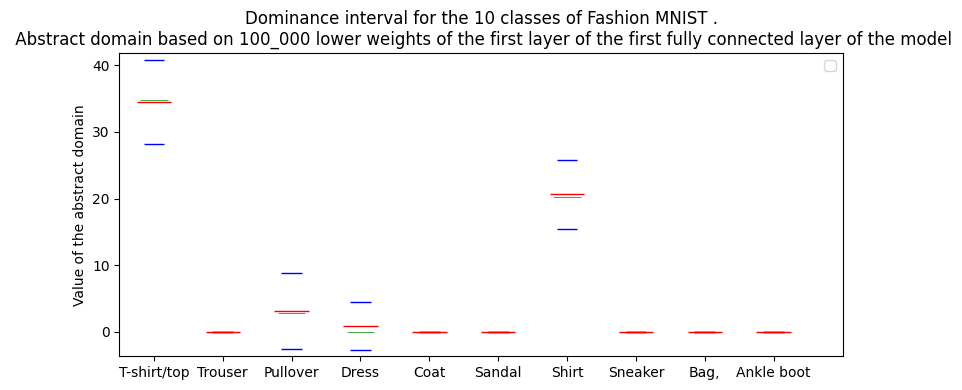

<Axes: title={'center': 'Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model'}, ylabel='Value of the abstract domain'>

In [360]:
result = result_list[1]
plot_dominance(*result[:4])

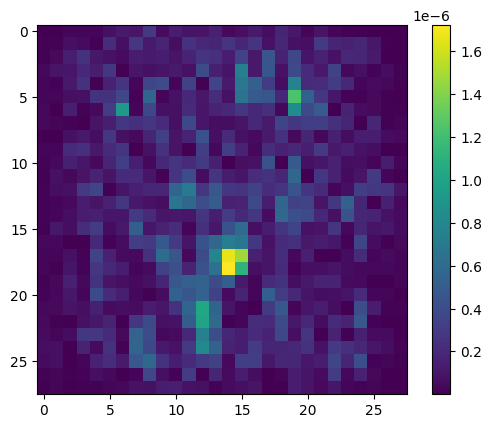

In [352]:

concat= torch.abs(img_relevance_list[0][2])

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')
plt.colorbar()

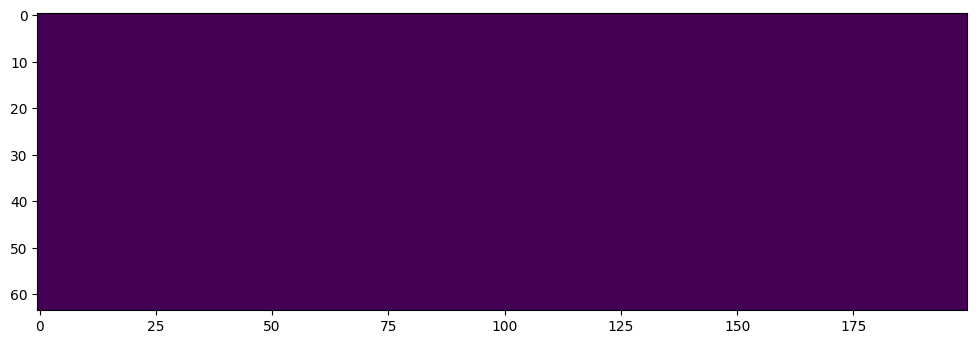

In [355]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12, 6)) 
plt.imshow(torch.abs(fc1_weight_relevance_list[0][1,:,200:400]))




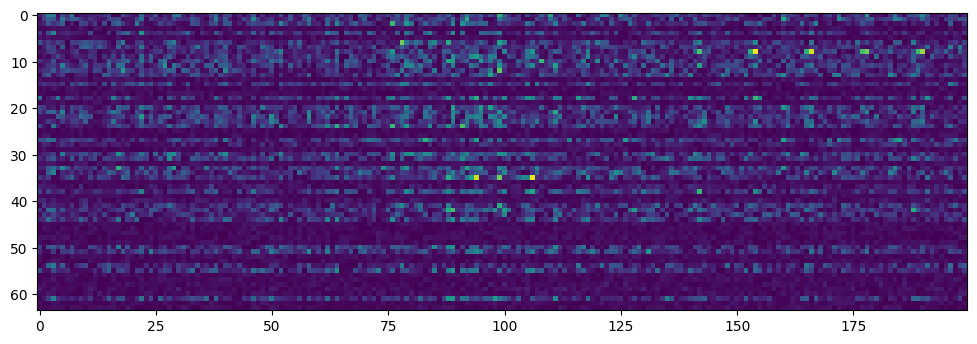

In [264]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12, 6)) 
plt.imshow(torch.abs(model.fc1[1].weight.data[:,200:400]))

In [302]:
label_list_number = np.arange(0,50,1)
label_list_number = np.array([int(label_list_number[i]/10) for i in label_list_number])

In [303]:
label_list_number

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

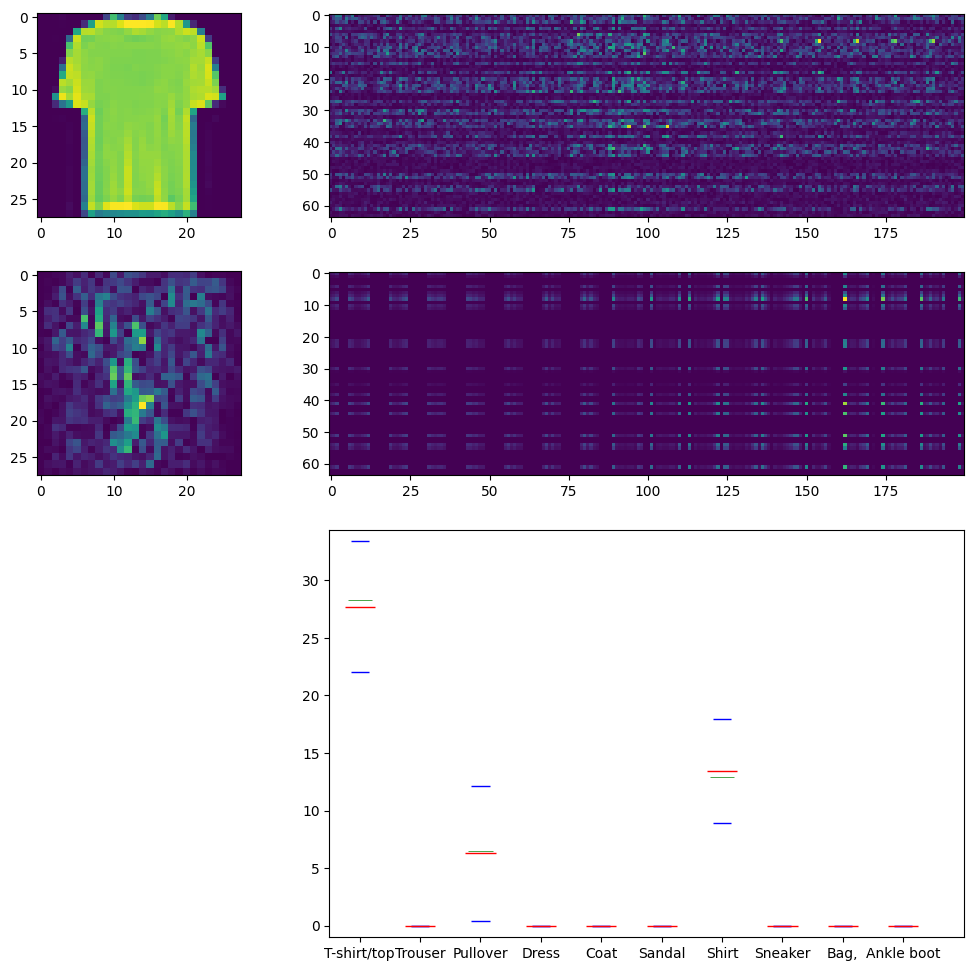

In [418]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(3, 2, figsize = (12, 12),gridspec_kw={'width_ratios': [1,3],'height_ratios': [1, 1, 2]})
def init():
    ax[2,1].cla()
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[0][0])
    ax[0,1].imshow(np.abs(model.fc1[1].weight.data[:,200:400]))
    ax[1,0].imshow(np.abs(img_relevance_list[0][0].reshape(28,28)))

    ax[1,1].imshow(np.abs(array_list_fc1[0][label_list_number[0],:,200:400]))
   
    result,y_min,y_max,y_true = result_list[0][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:

    
    ax[2,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[2,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[2,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    ax[2,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    ax[2,0].axis('off')
  
    
 
    return [ax]

def update(frame):
    
    ax[2,1].cla()
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[frame][0])
    ax[0,1].imshow(np.abs(model.fc1[1].weight.data[:,200:400]))
    ax[1,0].imshow(np.abs(img_relevance_list[frame][num_label_list[frame]].reshape(28,28)))
   

    ax[1,1].imshow(np.abs(array_list_fc1[frame][num_label_list[frame],:,200:400]))
    result,y_min,y_max,y_true = result_list[frame][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:
    ax[2,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    
    ax[2,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[2,1].plot([num_label_list[frame], num_label_list[frame]], [y_min[num_label_list[frame]], y_max[num_label_list[frame]]], color='red') 
    ax[2,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[2,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    
    ax[2,0].axis('off')


    plt.title(f'Inference over {name_label_list[frame]} ; Relevance of fc1 layer IAW {label_list_number[frame]} label.')

    return [ax]


animation = FuncAnimation(fig, update, frames=50, init_func=init)

output_video = 'Abstract_network_relevance_dominance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [280]:

array = torch.randn(3,3,3)
array

tensor([[[-0.0971,  1.8829,  0.6715],
         [-0.4348, -0.3710, -0.1305],
         [-1.1697,  0.3712, -0.6378]],

        [[-1.8042,  1.0049,  1.1337],
         [ 0.8545,  1.2368, -1.4549],
         [ 0.1998,  0.2309, -0.1748]],

        [[-1.5012,  0.0799, -1.7277],
         [ 0.7552,  0.4155, -0.3586],
         [ 0.4779, -0.1827,  1.2072]]])

In [282]:
array[0][2]

tensor([-1.1697,  0.3712, -0.6378])

In [362]:
import pickle
total_list = [img_list,
img_relevance_list,
conv1_weight_relevance_list, 
conv1_bias_relevance_list,
conv2_weight_relevance_list,
conv2_bias_relevance_list, 

fc1_weight_relevance_list, 
fc1_bias_relevance_list, 
fc2_weight_relevance_list, 
fc2_bias_relevance_list,  
result_list,
num_label_list,
name_label_list, 
true_predict_list] 


file_path = 'my_list.pkl'


with open(file_path, 'wb') as file:
 
    pickle.dump(total_list, file)

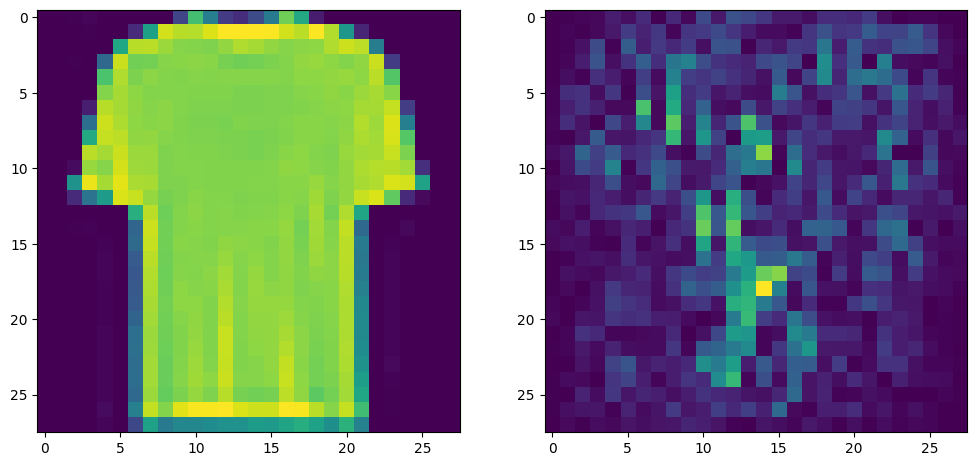

In [423]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(1, 2, figsize = (12, 6),gridspec_kw={'width_ratios': [1,1]})
def init():
  
   
    ax[0].imshow(array_list_img[0][0])

    ax[1].imshow(np.abs(img_relevance_list[0][0].reshape(28,28)))

    
  
    
 
    return [ax]

def update(frame):
    
  
   
    ax[0].imshow(array_list_img[frame+20][0])

    ax[1].imshow(np.abs(img_relevance_list[frame+20][num_label_list[frame+20]].reshape(28,28)))
   






    return [ax]


animation = FuncAnimation(fig, update, frames=20, init_func=init)

output_video = 'Abstract_network_relevance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])